# R-group Decomposition with Regression Analysis
In this project, we combine R-group decomposition and regression models to investigate how the physicochemical and structural properties of substituents influence the binding affinity of mu-opioid receptor ligands. We will prepare the data, train a regression model and use the model to predict the binding affinity of compounds with similar structures from PubChem.

Substituent descriptor data is multicollinear in nature. In addition, the fact that number of features will exceed the number of observations (i.e. number of compounds) implies multicollinearity.
To be able to estimate the effect of single descriptors in a multicollinear data set, we will use regularized linear regression models (such as Ridge, Lasso and/or ElasticNet).

Data from ChEMBL (all reported human mu-opioid ligands with affinity data expressed as Ki).

### Structure of the project
1. Exploratory data analysis and dataset preparation
2. Preprocessing, model selection and training
3. Prediction of activities of PubChem compounds

### Limitations:
- Ki data may come from different assays. Data collection with different assays may introduce assay-specific biases. We can try to address this by identifying groupings in data and using appropriate strategies (e.g. group K-fold validation)
- Small dataset

## 1 - EDA and Dataset Preparation

### **Import libraries and define functions**

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scaffoldgraph as sg
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import mols2grid
import seaborn as sns

def getMolDescriptorsDF(smiles_list, missingVal=None):
    '''
    Takes a list of SMILES strings and calculates descriptors for each SMILES string.
    The descriptors are stored in a DataFrame with each descriptor value in a separate column.
    Slightly modified from https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html to return a dataframe.

    Args:
    - smiles_list (list): List of SMILES strings for which descriptors are calculated.
    - missingVal (optional): Value to be used for descriptors that cannot be calculated.

    Returns:
    - res (DataFrame): DataFrame containing calculated descriptors for each SMILES string.
    '''

    df_list = []
    columns = list(zip(*Descriptors._descList))[0]
    
    
    for smiles in smiles_list:
        data = []
        mol = Chem.MolFromSmiles(smiles)
        
        for nm, fn in Descriptors._descList:
            # Some of the descriptor functions can throw errors if they fail, catch those here:
            try:
                val = fn(mol)
            except:
                # Print the error message:
                import traceback
                traceback.print_exc()
                # Set the descriptor value to whatever missingVal is
                val = missingVal
                
            data.append(val)

        
        df_desc = pd.DataFrame([data], columns=columns)
        df_desc[['Substituent']] = smiles
        df_desc.set_index('Substituent', inplace = True)
        df_list.append(df_desc)
    
    res = pd.concat(df_list, axis=0, ignore_index=False)
    return res


### **Read data**

In [164]:
df = (pd.read_csv("mu_opioid_ligands_chembl.tsv",
                 sep='\t', 
                  usecols=['Molecule ChEMBL ID', 'Smiles','Standard Value', 'Assay ChEMBL ID', 'BAO Label'])
                 .rename(columns={'Molecule ChEMBL ID': 'ID', 'Smiles': 'SMILES', 'Standard Value':'Ki (nM)'})
     )

### **Data Preprocessing**

*1 - Check for NaNs.* 

Rows with missing SMILES or Ki values are removed.

In [165]:
# count NaNs in dataframe
df.isna().sum()

ID                    0
SMILES               62
Ki (nM)            1001
Assay ChEMBL ID       0
BAO Label             0
dtype: int64

In [166]:
# drop NaNs 
df = df.dropna(axis=0).reset_index(drop = True)

*2 - Duplicate compounds*

In [167]:
df['CanonSMILES'] = df.SMILES.apply(Chem.CanonSmiles)

# drop duplicates
# values are first sorted in ascending order of Ki so that, in case of duplicates, the lowest Ki is kept
df = (df.sort_values(by = 'Ki (nM)')
      .drop_duplicates(subset='CanonSMILES', keep='first'))

*3 - Check dtypes*

Experimental results from assays may be reported in non numerical formats (typically >*number*) in an object column. Data from ChEMBL usually has the operators (>, <, =) in a separate column and there is no need to fix the format in this case.


In [168]:
df.dtypes

ID                  object
SMILES              object
Ki (nM)            float64
Assay ChEMBL ID     object
BAO Label           object
CanonSMILES         object
dtype: object

In [169]:
df.shape

(4721, 6)

*4 - Categorical variables*

We can convert BAO labels to categorical.

In [170]:
df['BAO Label'] = df['BAO Label'].astype('category')

df.groupby(by='BAO Label').nunique()

,ID,SMILES,Ki (nM),Assay ChEMBL ID,CanonSMILES
BAO Label,,,,,
assay format,554,554,513,26,554
cell membrane format,260,260,212,13,260
cell-based format,3040,3040,1421,268,3040
single protein format,867,867,556,138,867


BioAssay Ontology (BAO) labels are used to categorize assays (https://www.ebi.ac.uk/ols/ontologies/bao). There are 4 BAO labels in this dataset: *cell-based format*, *single protein format* and *cell membrane format* identify a specific assay format, while *assay format* is a parent category. Looking back at the original data file, it looks like *assay format* includes 26 assays which have not been categorized by format. It could be possible to use domain knowledge to manually assign them to a specific category. For this, let's just keep them as a separate *assay format* category. 

### Selection of scaffold series and further analysis

The dataframe contains a collection of molecules with different scaffolds. To perform R-group decomposition, we select a group of molecules based on the same scaffold. We use scaffoldfgraph to extract all the scaffolds present in the dataset.

We visualize the scaffolds present and the count of molecules containing each scaffold to select the scaffold we want to do R-group decomposition on. To get interesting results, we select a scaffold that's not too simple (e.g. no common single rings) but also has a relatively high count.
For example, we can choose 4-phenyl-piperidine (319 molecules count). 

In [171]:
# add a mol column
PandasTools.AddMoleculeColumnToFrame(df,'CanonSMILES','Mol')

# extract all Murcko substructures for each mol and convert to SMILES
df['MurckoFrags'] = [sg.get_all_murcko_fragments(mol, break_fused_rings= False) for mol in df['Mol']]
df = df.explode('MurckoFrags')
df['FragSMILES'] = df.MurckoFrags.apply(lambda x: Chem.MolToSmiles(x))

# create a dataframe with the counts of molecules for each substructures 

grouped = (df.groupby('FragSMILES')['CanonSMILES']
           .nunique()
           .sort_values(ascending = False)
           .reset_index()
           .rename({'CanonSMILES':'Counts'}, axis = 1)
          )


mols2grid.display(grouped, smiles_col='FragSMILES', subset = ['img','Counts'])

C:\Users\a_cas\anaconda3\envs\rdkit_38\lib\site-packages\mols2grid\select.py:25: UserWarning: Overwriting non-empty 'default' grid selection: {6: 'c1ccc(C2CCNCC2)cc1'}
  warnings.warn(


MolGridWidget()

In [172]:
#get selection from mol2grid
sub_list = list(mols2grid.get_selection().values())

if len(sub_list)==1:
    substructure = list(mols2grid.get_selection().values())[0]
else:
    print('Error: select one substructure')

#filter original dataset based on substructure
df_sub = df[df['FragSMILES'] == substructure].reset_index(drop= True)                                                         

We can now analyze the filtered dataset in more detail.

*1 - Distribution of dependent variable*

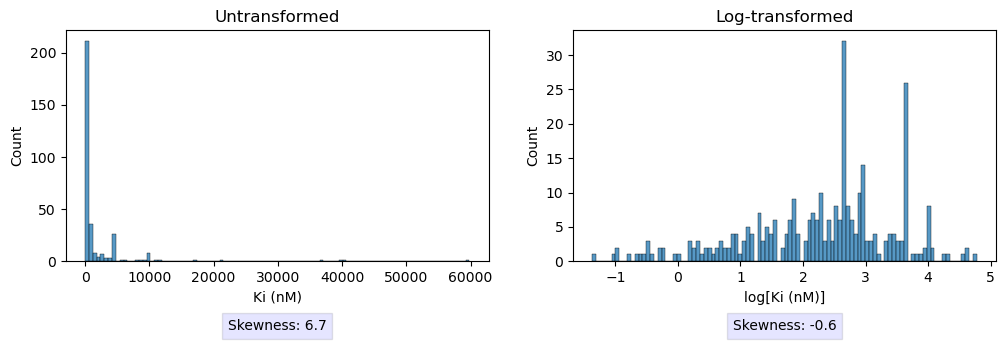

In [173]:
skew_untrans = str(round(df_sub['Ki (nM)'].skew(), 1))
skew_trans = str(round(np.log10(df_sub['Ki (nM)']).skew(), 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

sns.histplot(x= df_sub['Ki (nM)'], bins=100, ax=axs[0])
axs[0].set_title('Untransformed')
axs[0].text(0.5, -0.25, 'Skewness: ' + skew_untrans, ha = 'center', va = 'top', transform=axs[0].transAxes, bbox=dict(facecolor='blue', alpha=0.1));

sns.histplot(x=np.log10(df_sub['Ki (nM)']), bins=100, ax=axs[1])
axs[1].set_title('Log-transformed')
axs[1].set_xlabel('log[Ki (nM)]')
axs[1].text(0.5, -0.25, 'Skewness: ' + skew_trans, ha = 'center', va = 'top', transform=axs[1].transAxes, bbox=dict(facecolor='blue', alpha=0.1));

Ki values are highly right skewed. Log-transformation reduces skewness, even though a smaller left skew is still present. Less skewed data may improve the model fit and we will consider applying a log-transformation before training the model.
There are peaks around 5000 and 10000 (~3.7 and 4 on the log scale) likely caused by the consolidation of multiple values of the form ">5000" or ">10000".

*2 - Groupings by assay and assay type*

Data from ChEMBL comes from a variety of different assays, the results of which may or may not be directly comparable. We want to know the structure of these groupings and choose strategies that can counteract the potential bias introduced by different data collection methods (e.g. in the sampling of the test set or cross-validation folds).

It seems like for this specific scaffold, the data has been collected with 37 different assays, divided in the 4 BAO categories seen above. 

In [174]:
df_sub.nunique()

ID                 319
SMILES             319
Ki (nM)            219
Assay ChEMBL ID     37
BAO Label            4
CanonSMILES        319
Mol                319
MurckoFrags        319
FragSMILES           1
dtype: int64

We want to include the BAO label as a feature for the model training. In notebook 2 of this project, we will encode BAO labels with one-hot encoding.

### R-group decomposition

In [175]:
# R-group decomposition
rgd,failed = rdRGroupDecomposition.RGroupDecompose([Chem.MolFromSmiles(substructure)],df_sub.Mol.values,asRows=True, asSmiles = True)

# merge with original df
df_merge = pd.merge(df_sub[['ID','CanonSMILES','Ki (nM)', 'BAO Label']], pd.DataFrame(rgd), left_index = True, right_index = True)

# extract core for later use
core = Chem.MolFromSmiles(df_merge.Core.unique()[0])

# unpivot all R-groups in a single column to calculate descriptors
r_list = df_merge.columns[5:].to_list() #extract value variables from df
df_melt = df_merge.melt(id_vars = ['ID', 'CanonSMILES','Ki (nM)', 'BAO Label'], value_vars = r_list).rename({'variable':'R-group', 'value':'Substituent'}, axis = 1)

df_melt.head()

,ID,CanonSMILES,Ki (nM),BAO Label,R-group,Substituent
0,CHEMBL300662,C[C@H]1CN(CC[C@H](O)C2CCCCC2)CC[C@@]1(C)c1cccc...,0.043,cell-based format,R1,[H][*:1]
1,CHEMBL320218,C[C@H]1CN(CCCc2ccccc2)CC[C@@]1(C)c1cccc(O)c1,0.100,cell-based format,R1,[H][*:1]
2,CHEMBL421665,CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)c(C(F)(F)F)c2)...,0.110,single protein format,R1,[H][*:1]
3,CHEMBL364625,COC(=O)C(CCN1CCC(O)(c2cccc(C(F)(F)F)c2)CC1)(c1...,0.110,single protein format,R1,[H][*:1]
4,CHEMBL186795,CN(C)C(=O)C(CCN1CCC(O)(c2cccc(C(F)(F)F)c2)CC1)...,0.160,single protein format,R1,[H][*:1]


### Calculate descriptors

Descriptors are calculate using the getMolDescriptorsDF function (throws a lot of warnings).

In [176]:
# extract list of substituents
subs_smiles = list(df_melt['Substituent'].unique())

# create descriptors df
df_descriptors = getMolDescriptorsDF(subs_smiles)
df_descriptors.head()

[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:06:41] WARNING: not removing hydrogen atom with

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
Substituent,,,,,,,,,,,,,,,,,,,,,
[H][*:1],6.000000,6.000000,0.000000,0.000000,0.332332,1.008,0.000,1.007825,1,0,...,0,0,0,0,0,0,0,0,0,0
NC[*:1],4.958333,4.958333,0.541667,0.541667,0.379722,30.050,26.018,30.034374,13,0,...,0,0,0,0,0,0,0,0,0,0
Cl[*:1],4.888889,4.888889,0.222222,0.222222,0.370100,35.453,35.453,34.968853,7,0,...,0,0,0,0,0,0,0,0,0,0
C[*:1],2.250000,2.250000,0.750000,0.750000,0.358360,15.035,12.011,15.023475,7,0,...,0,0,0,0,0,0,0,0,0,0
C1CN(C[*:1])CCO1,5.187639,5.187639,0.591944,0.591944,0.453177,100.141,90.061,100.076239,41,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# to create a dataframe of features for linear regression:
# 1 - merge df_descriptors back on df_melt
# 2 - unpivot the resulting df so that each descriptor of substituents in each R position are on different columns

desc_list = [desc[0] for desc in Descriptors._descList] # extract list of descriptors for pivot values

df_features = (df_descriptors
               .merge(df_melt, left_index = True, right_on = 'Substituent')
               .pivot(index = ['ID', 'Ki (nM)', 'BAO Label'], columns = 'R-group', values = desc_list)
              )

# flatten column index and convert Ki column to value column                
df_features.columns = [f"{x}_{y}" for x, y in df_features.columns.to_flat_index()]
df_features.reset_index(level = ['Ki (nM)', 'BAO Label'], inplace = True)
              
df_features.head()

,Ki (nM),BAO Label,MaxAbsEStateIndex_R1,MaxAbsEStateIndex_R2,MaxAbsEStateIndex_R3,MaxAbsEStateIndex_R4,MaxAbsEStateIndex_R5,MaxAbsEStateIndex_R6,MaxAbsEStateIndex_R7,MaxAbsEStateIndex_R8,...,fr_unbrch_alkane_R7,fr_unbrch_alkane_R8,fr_urea_R1,fr_urea_R2,fr_urea_R3,fr_urea_R4,fr_urea_R5,fr_urea_R6,fr_urea_R7,fr_urea_R8
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL10872,33.1,single protein format,6.0,6.0,12.335818,2.25,2.25,6.0,7.250000,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL109509,104.0,single protein format,6.0,6.0,12.039158,6.00,7.25,6.0,10.465278,4.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL109563,46.0,assay format,6.0,6.0,2.319230,6.00,7.25,6.0,10.465278,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL109598,124.0,assay format,6.0,6.0,1.666667,6.00,7.25,6.0,10.465278,4.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL111192,36.0,assay format,6.0,6.0,2.382167,6.00,7.25,6.0,10.465278,6.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
df_features.shape

(319, 1674)

Now we have a dataframe with all features (descriptors for each substituent for each R position) as single columns, which will be used to train the model.

Before that, further analyses can be performed.

### Further analysis and finalization

*1 - Check dtypes*

In [179]:
df_features.dtypes.unique()

array([dtype('float64'),
       CategoricalDtype(categories=['assay format', 'cell membrane format', 'cell-based format',
                         'single protein format'],
       , ordered=False)                                                                         ],
      dtype=object)

As expected, we have all float64 columns except 'BAO Label' (categorical, dtype = object).

*2 - Check NaNs*

In [180]:
df_features.isna().sum().sum()

30624

The dataframe contains ~30000 missing values. To decide how to deal with them, we need to take a closer look. Let's look at the columns containing NaNs:

In [181]:
df_nans = df_features.loc[:, df_features.isnull().any()]
df_nans.head()

,MaxPartialCharge_R1,MaxPartialCharge_R2,MaxPartialCharge_R3,MaxPartialCharge_R4,MaxPartialCharge_R5,MaxPartialCharge_R6,MaxPartialCharge_R7,MaxPartialCharge_R8,MinPartialCharge_R1,MinPartialCharge_R2,...,BCUT2D_MRHI_R7,BCUT2D_MRHI_R8,BCUT2D_MRLOW_R1,BCUT2D_MRLOW_R2,BCUT2D_MRLOW_R3,BCUT2D_MRLOW_R4,BCUT2D_MRLOW_R5,BCUT2D_MRLOW_R6,BCUT2D_MRLOW_R7,BCUT2D_MRLOW_R8
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL10872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL109509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL109563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL109598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL111192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All missing values are connected to 12 descriptors and it looks like there were issues with calculating the descriptor irrespective of the type of substituent (i.e. in all R positions). This hints at an issue with calculating certain descriptors with the particular format of R-group substituents, rather than with specific substituents. We can confirm that this is the case by checking if all values for all molecules are missing (i.e. if df_nans contains only NaNs). If that's the case, it should be safe to drop the columns with NaNs from df_features and continue with the analysis.

In [182]:
df_nans.isna().all().unique()

array([ True])

In [183]:
df_features = df_features.dropna(axis=1)
df_features.shape

(319, 1578)

*3 - Visualize correlations between features*

For ease of visualization, we only include selected features of R1 substituents.

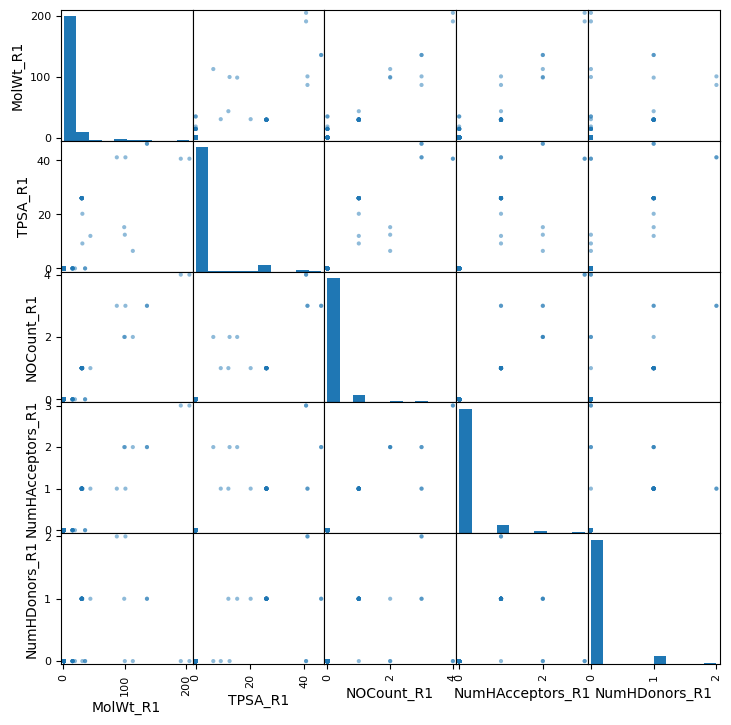

In [184]:
features = ['MolWt_R1', 'TPSA_R1', 'NOCount_R1', 'NumHAcceptors_R1', 'NumHDonors_R1']
pd.plotting.scatter_matrix(df_features[features], figsize =(8.5,8.5));

This (limited) example has just a few data points but we can clearly see some correlations, as expected. This reinforces the idea of multicollinear data and the need for a regularized regression models.
The dataset is now ready for preprocessing and model training in Notebook 2.